In [1]:
import numpy as np
import awkward as ak
import fastjet
import uproot as ur
import matplotlib.colors as mcolors
import mplhep as hep
import matplotlib.pyplot as plt
import math
import matplotlib as colors
import matplotlib as abc
from scipy.optimize import curve_fit
import pandas as pd
from iminuit import Minuit
from iminuit.cost import LeastSquares
import pickle
from scipy.interpolate import UnivariateSpline

hep.style.use(hep.style.CMS)
hep.style.use("CMS")
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [11]:
lowerRange = 20
upperRange = 90
width = 5
generator = "P8H"
scale = "P8H"
with open('JetDFs/{}Reco.pickle'.format(generator), 'rb') as handle:
    reco_dict_test = pickle.load(handle)
with open('JetDFs/{}Gen.pickle'.format(generator), 'rb') as handle:
    gen_dict_test = pickle.load(handle)
with open('Scale2D_{}.pickle'.format(scale), 'rb') as f:
    EtaSlice, AvgEReco, AvgERecoErr, AvgR, AvgRErr = pickle.load(f)

0.40000000000000036


5


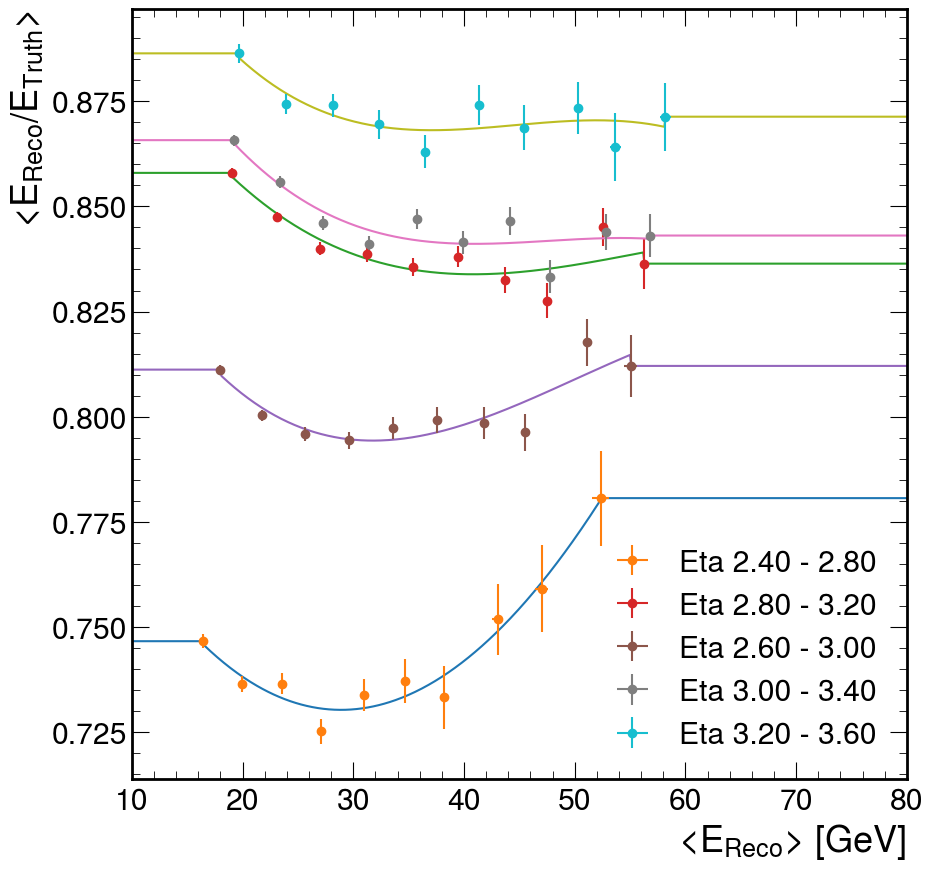

In [27]:
def custom_spline(x):
    if isinstance(x, (list, np.ndarray)):
        return np.array([custom_spline(xi) for xi in x])
    if x <= np.array(AvgEReco)[mask][-1] and x >= np.array(AvgEReco)[mask][0]:
        return spl(x)
    elif x >= np.array(AvgEReco)[mask][-1]:
        return np.array(AvgR)[mask][-1]
    else:
        return np.array(AvgR)[mask][0]
        
splines = {}

for i in set(EtaSlice): 
    mask = (np.array(EtaSlice) == i)
    spl = UnivariateSpline(np.array(AvgEReco)[mask], np.array(AvgR)[mask], k=3, s=0.1)
    splines[i] = custom_spline
    xnew = np.linspace(0, 100, num=1001)
    plt.plot(xnew,custom_spline(xnew))
    plt.errorbar(np.array(AvgEReco)[mask],np.array(AvgR)[mask],xerr=np.array(AvgERecoErr)[mask],yerr=np.array(AvgRErr)[mask],fmt="o",label="Eta %2.2f - %2.2f"%(i-(EtaWidth/2), i + (EtaWidth/2)))
    
plt.xlim(10,80)
plt.ylabel(r"<$E_{Reco}$/$E_{Truth}$>")
plt.xlabel(r"<$E_{Reco}$> [GeV]")
plt.legend()
print(len(splines))

In [4]:
print(len(reco_dict_test["energy"]))

1000000


In [17]:
mask = (ak.flatten(reco_dict_test["matched_index_new"]) > -1)
matchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
matchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
matchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) > -1
matchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
matchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
matchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

mask = ak.flatten(reco_dict_test["matched_index_new"]) == -1
unmatchedJetEtest = ak.flatten(reco_dict_test["energy"])[mask]
unmatchedJetEtatest = ak.flatten(reco_dict_test["eta"])[mask]
unmatchedJetPhitest = ak.flatten(reco_dict_test["phi"])[mask]

mask = ak.flatten(gen_dict_test["matched_index_new"]) == -1
unmatchedGjetEtest = ak.flatten(gen_dict_test["energy"])[mask]
unmatchedGjetEtatest = ak.flatten(gen_dict_test["eta"])[mask]
unmatchedGjetPhitest = ak.flatten(gen_dict_test["phi"])[mask]

allRecoE = ak.flatten(reco_dict_test["energy"])

In [19]:
PairedGenEtest = matchedGjetEtest
PairedRecoEtest = matchedJetEtest
JetRtest = PairedRecoEtest/PairedGenEtest

In [37]:
# Function to find the closest key in the dictionary
def find_closest_key(dictionary, target):
    return min(dictionary.keys(), key=lambda x: abs(x - target))

# Define a function that calculates the correction factor
def calculate_correction_factor(RecoE, RecoEta, splines):
    closest_eta = np.vectorize(lambda x: find_closest_key(splines, x))(RecoEta)
    correction_factor = np.vectorize(lambda x, eta: splines[eta](x))(RecoE, closest_eta)
    return RecoE / correction_factor


correctedReco = calculate_correction_factor(PairedRecoEtest, matchedJetEtatest, splines)
JetRC = correctedReco/PairedGenEtest

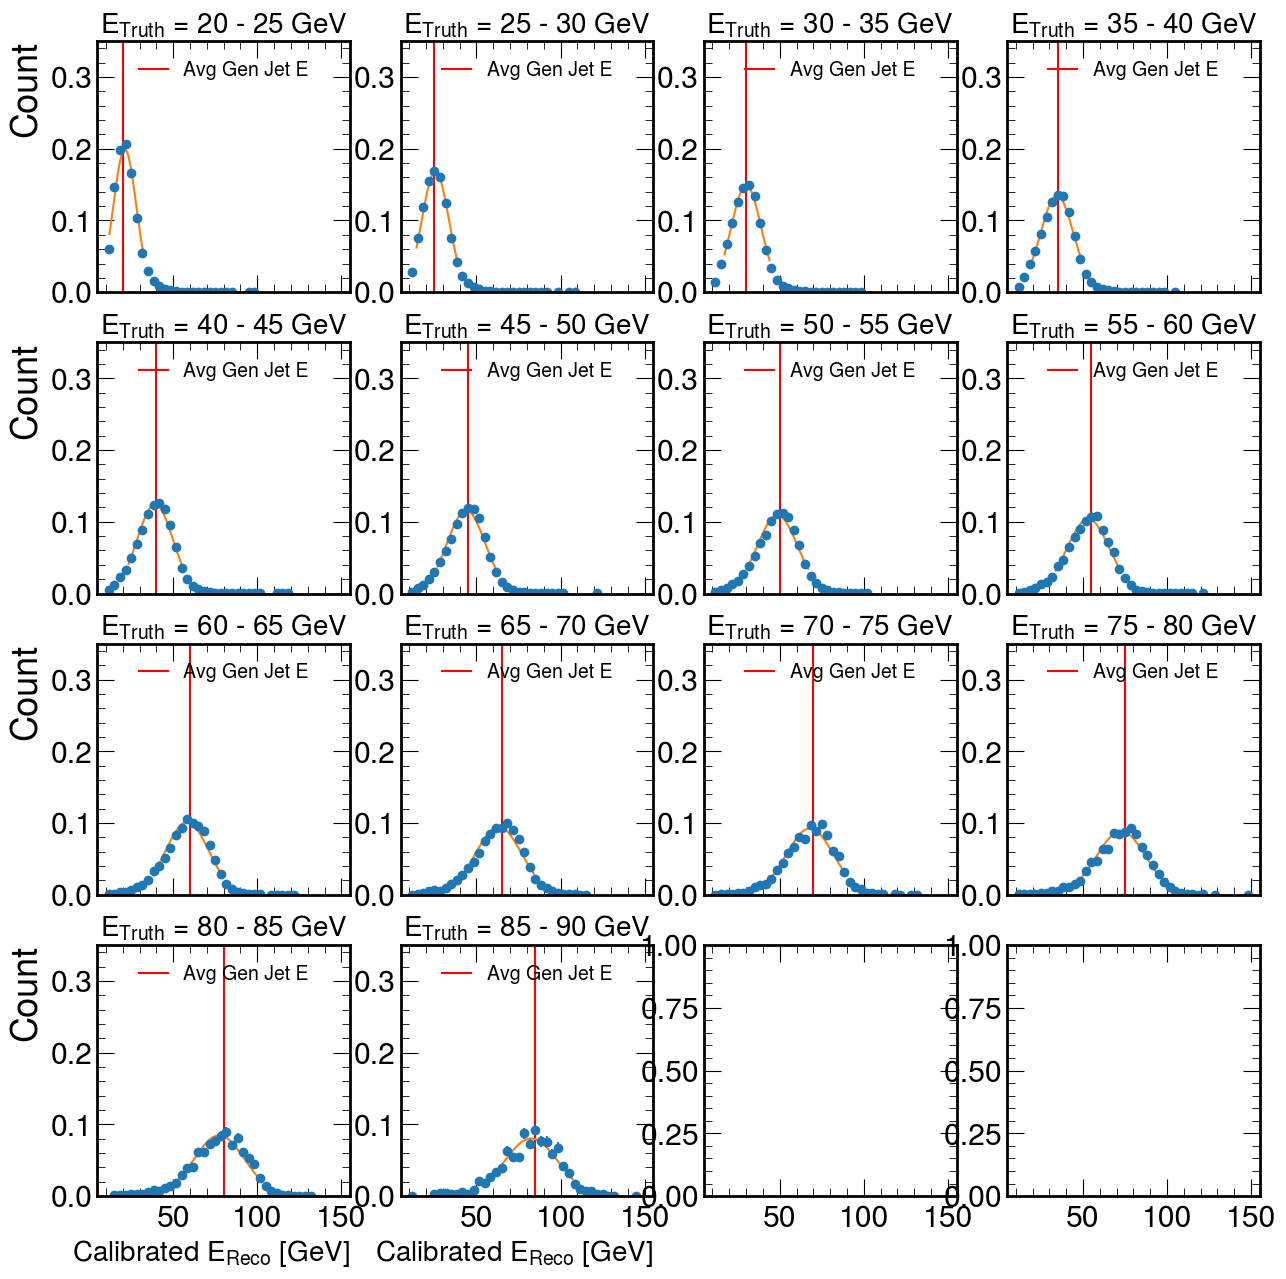

In [49]:
fig, axs=plt.subplots(4, 4, figsize=(15,15),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))


CAvgEReco = []
CAvgERecoErr = []

CNumEReco = []
CNumERecoErr = []

GenSlice = []

EBin = 0
for i in range(lowerRange,upperRange,width):
 
    x = (EBin) // 4  
    y = (EBin) % 4
    EBin += 1
    plt.sca(axs[x][y])
        
    genEBin = (PairedGenEtest > i) & (PairedGenEtest < i+width)
    
    hist, bin_edges = np.histogram(correctedReco[genEBin],bins=60,range=(0,200))
    
    
    zerocut = (hist > 0)
    total = np.sum(hist[zerocut])
    errs = np.sqrt(hist[zerocut]) / total
    hist = hist[zerocut] / total
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    bins = bin_centres[zerocut]
    
    minFit = bins[np.argmax(hist)] - 20
    maxFit = bins[np.argmax(hist)] + 20
    
    minFit = np.mean(correctedReco[genEBin]) - 1.5 * np.std(correctedReco[genEBin])
    maxFit = np.mean(correctedReco[genEBin]) + 1.5 * np.std(correctedReco[genEBin])

    fitCut = (bins > minFit) & (bins < maxFit)
    plt.errorbar(np.array(bins),np.array(hist),yerr=errs,fmt="o")
    
    plt.axvline(i,color='red', label="Avg Gen Jet E")

    
    least_squares = LeastSquares(list(bin_centres[zerocut]),list(hist),list(errs),gauss)
    m = Minuit(least_squares, A=max(hist), mu = i, sigma = np.std(correctedReco[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,120,5000), m.values[0],m.values[1],m.values[2])
    
    fitPlotCut = (np.linspace(0,150,5000) > minFit) & (np.linspace(0,150,5000) < maxFit)
    hist_fit = gauss(np.linspace(0,150,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
    plt.plot(np.linspace(0,150,5000)[fitPlotCut], hist_fit)
    
    plt.legend(loc='upper center',fontsize=14)
    CNumEReco.append(np.mean(correctedReco[genEBin]))
    CNumERecoErr.append(np.std(correctedReco[genEBin]))
    if not math.isnan(m.values[1]):
        CAvgEReco.append(m.values[1])
        CAvgERecoErr.append(m.errors[1])
    else:
        CAvgEReco.append(0)
        CAvgERecoErr.append(0)

    plt.ylim(0,0.35)
    if(y == 0):
        plt.ylabel("Count")
    if(x == 3):
        plt.xlabel(r"Calibrated $E_{Reco}$ [GeV]",fontsize=20)
    plt.title(r'$E_{Truth}$ = %2.0f - %2.0f GeV'%(i, i+width),fontsize=20)

#print(CAvgEReco)
#print(CAvgERecoErr)

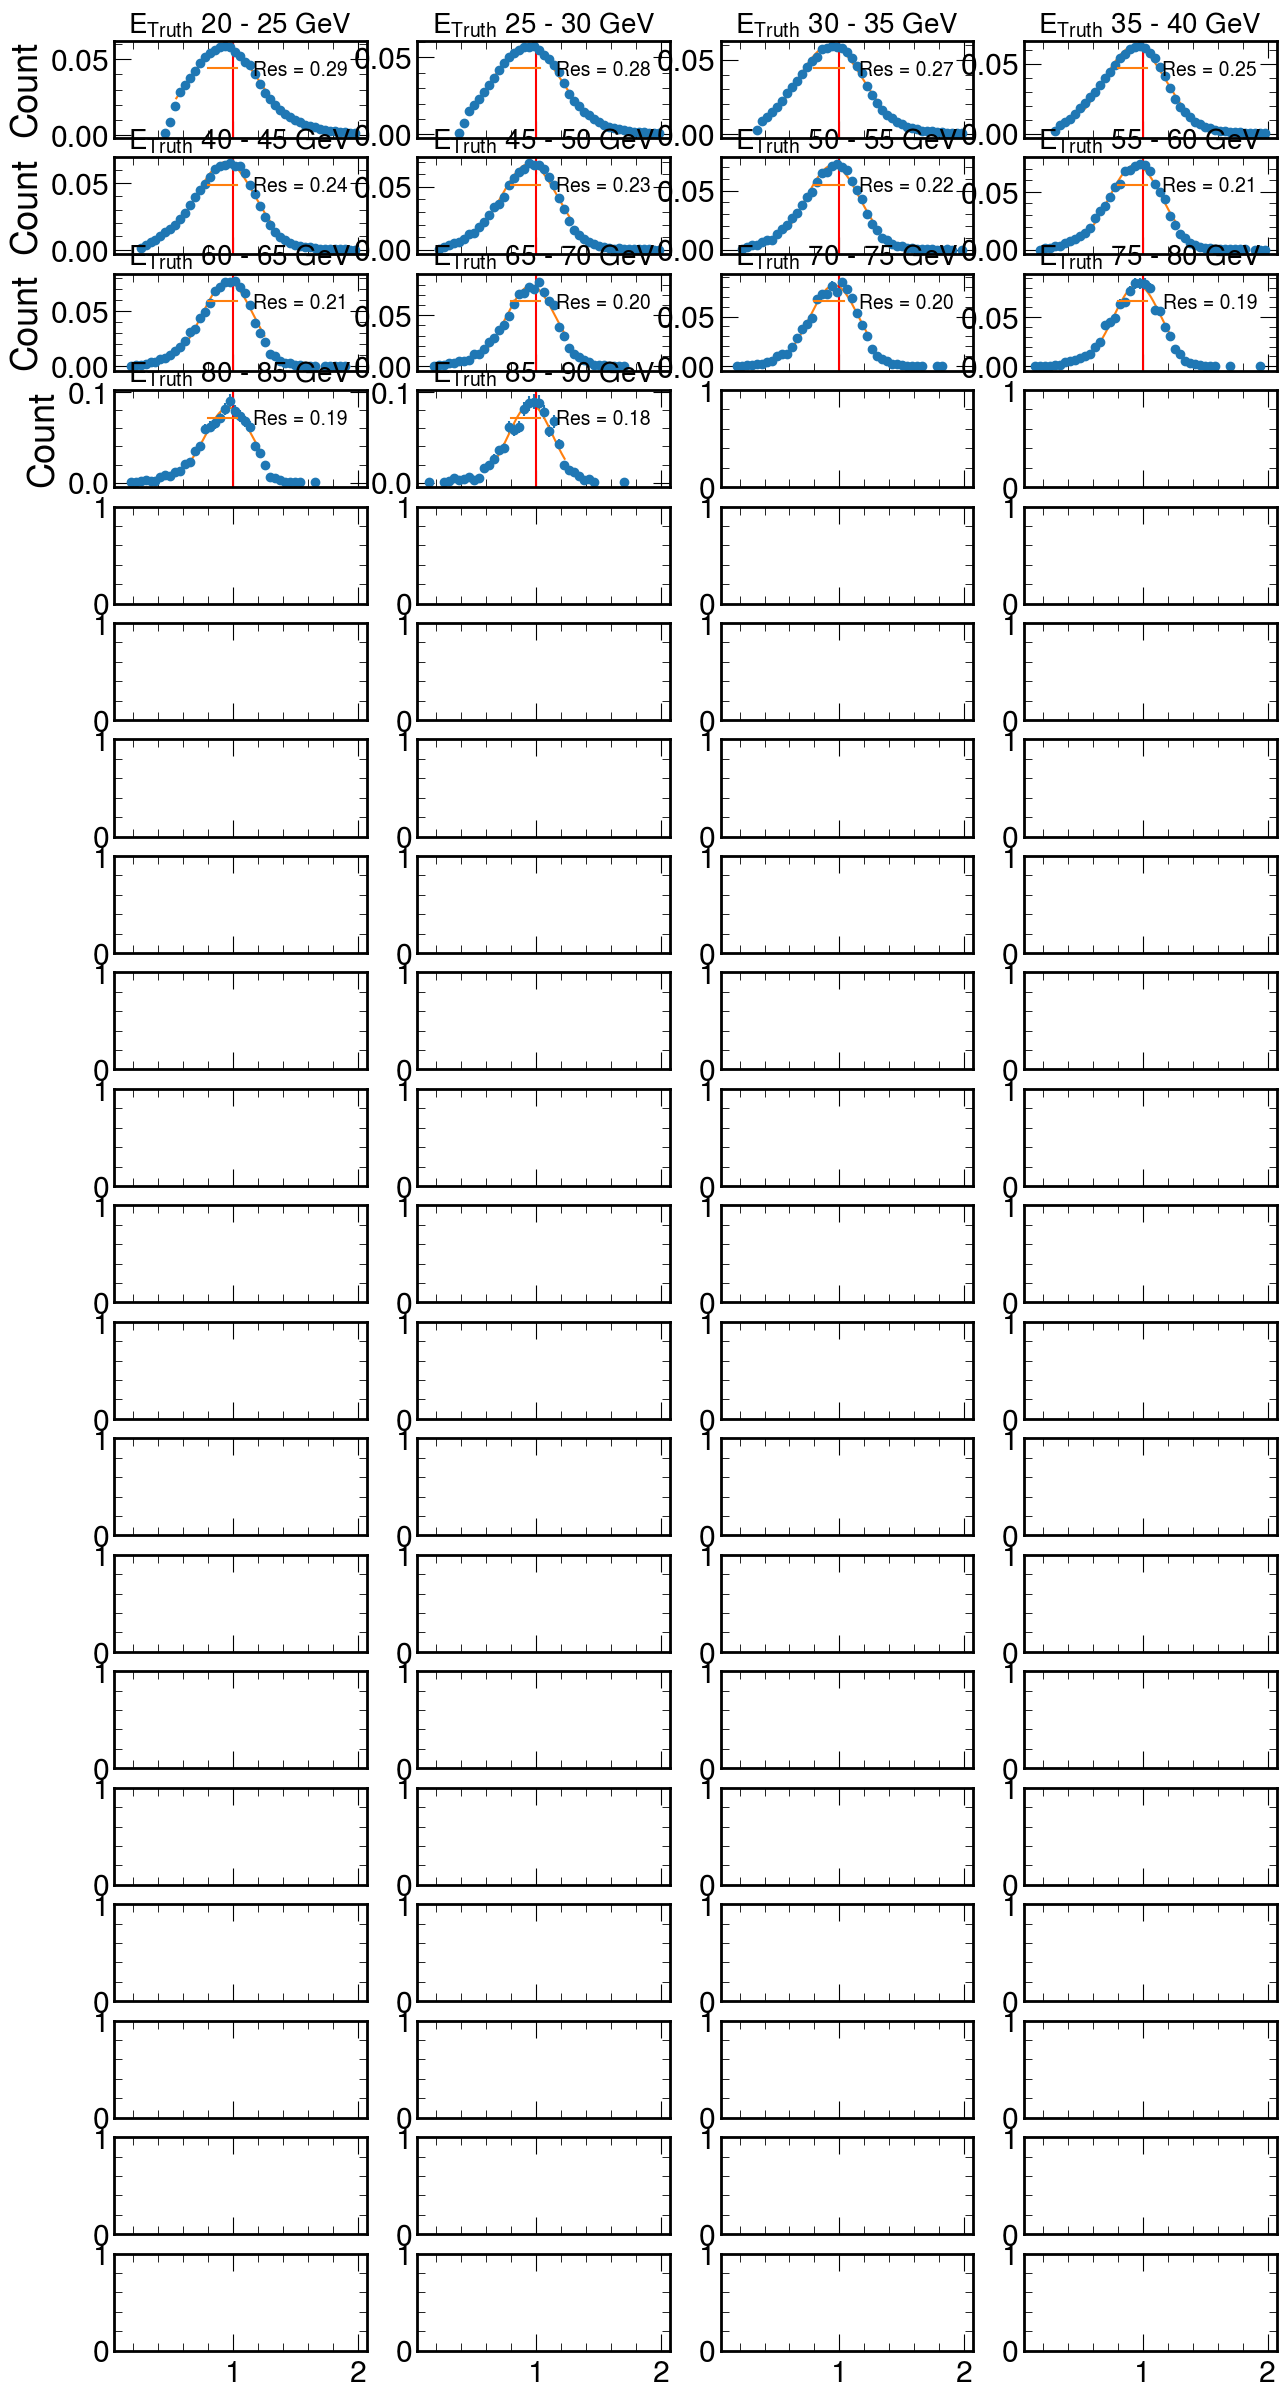

In [40]:
fig, axs=plt.subplots(20, 4, figsize=(15,30),sharex=True)
#fig.subplots_adjust(wspace=0.4, hspace=0)

def gauss(x, A, mu, sigma):
 
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

CAvgR = []
CAvgRErr = []

CNumR = []
CNumRErr = []

Res = []
ResErr = []

Sigma = []
SigmaErr = []

GenSlice = []
EBin = 0
for i in range(lowerRange,upperRange,width):
 
    x = (EBin) // 4  
    y = (EBin) % 4
    EBin += 1
    plt.sca(axs[x][y])
        
    genEBin = (PairedGenEtest > i) & (PairedGenEtest < i+(width))
    
    hist, bin_edges = np.histogram(JetRC[genEBin],bins=50,range=(0,2))
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
    zerocut = (hist > 0)
    errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
    hist = hist[zerocut] / np.sum(hist[zerocut])
    bins = bin_centres[zerocut]
    
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o")

    minFit = bins[np.argmax(hist)] - 0.5
    maxFit = bins[np.argmax(hist)] + 0.5
    minFit = np.mean(JetRC[genEBin]) - 1.5 * np.std(JetRC[genEBin])
    maxFit = np.mean(JetRC[genEBin]) + 1.5 * np.std(JetRC[genEBin])
 
    fitCut = (bins > minFit) & (bins < maxFit)
    
       
    least_squares = LeastSquares(list(bin_centres[zerocut][fitCut]),list(hist[fitCut]),list(errs[fitCut]),gauss)
    m = Minuit(least_squares, A=max(hist), mu = 1.0, sigma = np.std(JetRC[genEBin]))
    m.migrad()
    m.hesse()
    hist_fit = gauss(np.linspace(0,2,5000), m.values[0],m.values[1],m.values[2])
    fitPlotCut = (np.linspace(0,2,5000) > minFit) & (np.linspace(0,2,5000) < maxFit)
    hist_fit = gauss(np.linspace(0,2,5000)[fitPlotCut], m.values[0],m.values[1],m.values[2])
    
    plt.plot(np.linspace(0,2,5000)[fitPlotCut], hist_fit, label = "Res = %2.2f"%m.values[2])
    CNumR.append(np.mean(JetRC[genEBin]))
    CNumRErr.append(np.std(JetRC[genEBin]))
    plt.axvline(1,color='red')
    if (not math.isnan(m.values[1])):
        CAvgR.append(m.values[1])
        Res.append(np.abs(m.values[2])/m.values[1])

        ResErr.append(np.abs(m.errors[2])/ m.values[1])

        Sigma.append(np.abs(m.values[2]))

        SigmaErr.append(np.abs(m.errors[2]))

        CAvgRErr.append(m.errors[1])
    else:
        CAvgR.append(0)
        CAvgRErr.append(0)
    #plt.ylim(0,0.21)
    plt.legend(loc='upper right',fontsize=14)
    if(y == 0):
        plt.ylabel("Count")
    if(x == 7):
        plt.xlabel(r"Corrected $E_{Reco}$/$E_{Truth}$")
    plt.title(r'$E_{Truth}$ %2.0f - %2.0f GeV'%(i, i+(width)),fontsize=20)


#print(CAvgR)
#print(CAvgRErr)

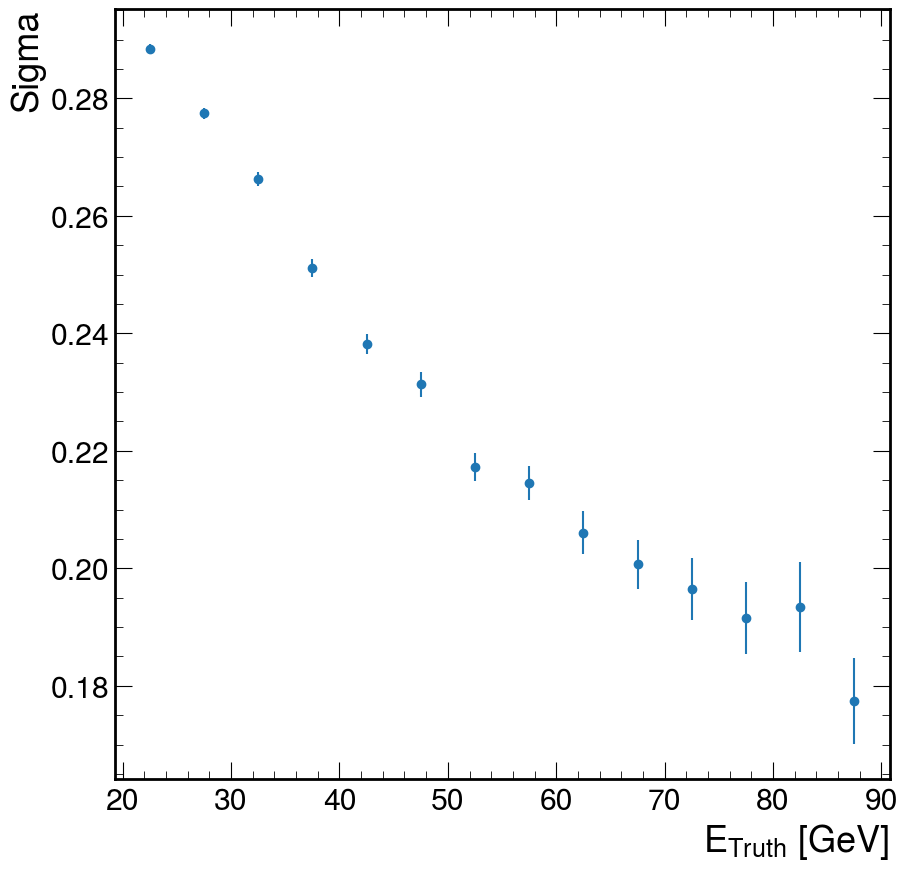

In [41]:
bin_centres = range(lowerRange,upperRange,width)

plt.errorbar(np.array(bin_centres)+(width/2),Sigma,yerr=SigmaErr,fmt="o")

plt.xlabel(r'$E_{Truth}$ [GeV]')
plt.ylabel('Sigma')

#plt.ylim(0,0.3)
with open('Sigma_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres)+(width/2), Sigma, SigmaErr), f)

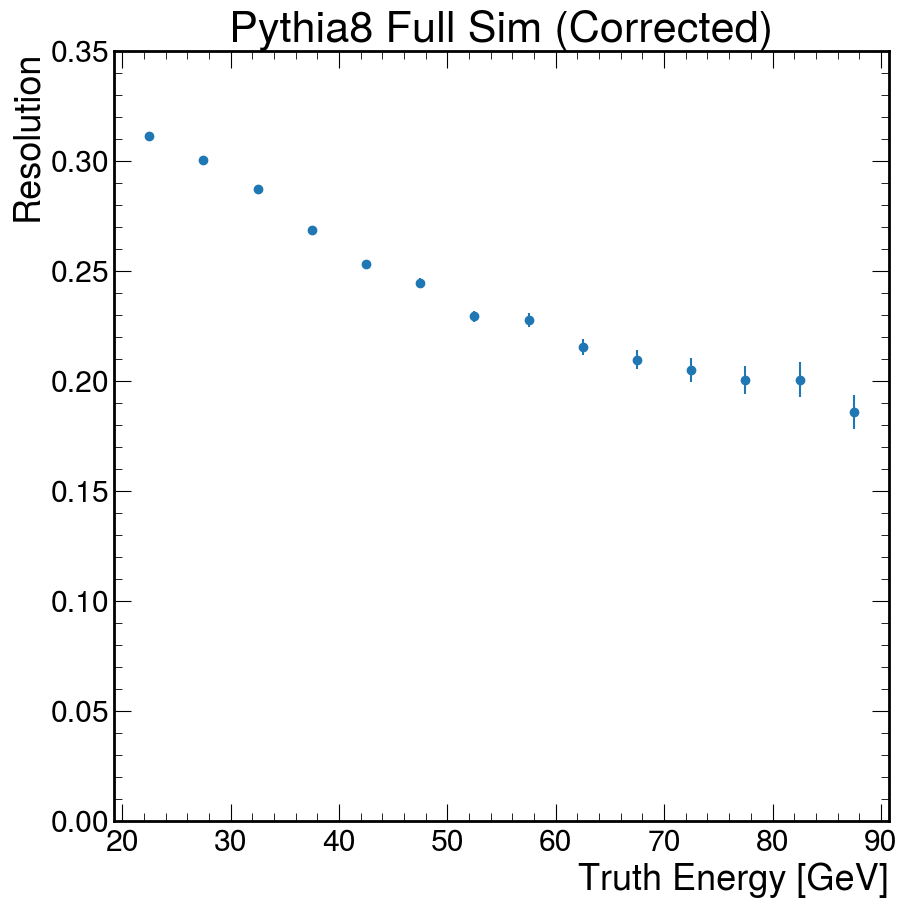

In [42]:
bin_centres = range(lowerRange,upperRange,width)

plt.errorbar(np.array(bin_centres)+(width/2),Res,yerr=ResErr,fmt="o")
plt.title("Pythia8 Full Sim (Corrected)")
plt.xlabel('Truth Energy [GeV]')
plt.ylabel('Resolution')
plt.ylim(0,0.35)
with open('Res_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres)+(width/2), Res, ResErr), f)

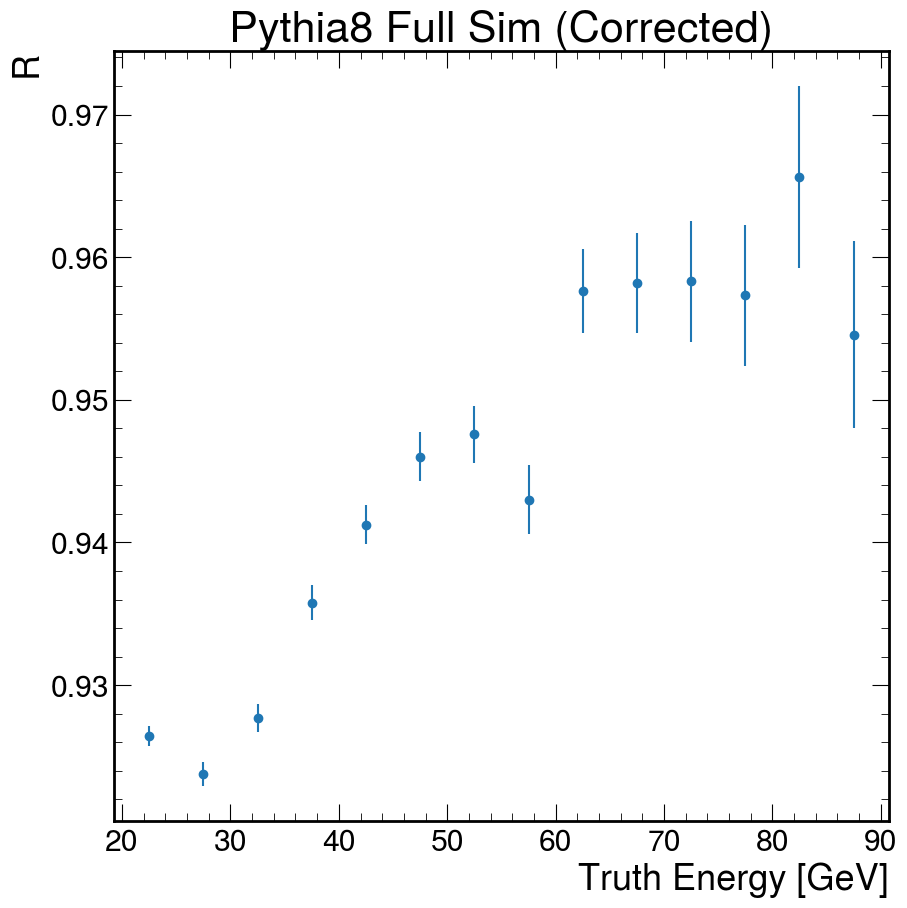

In [43]:


plt.errorbar(np.array(bin_centres)+(width/2),CAvgR,yerr=CAvgRErr,fmt="o")

plt.xlabel('Truth Energy [GeV]')
plt.ylabel('R')
plt.title("Pythia8 Full Sim (Corrected)")
#plt.ylim(0.9,1.0)
with open('R_{}_C{}_2D.pickle'.format(generator,scale), 'wb') as f:
    pickle.dump((np.array(bin_centres)+(width/2), CAvgR, CAvgRErr), f)

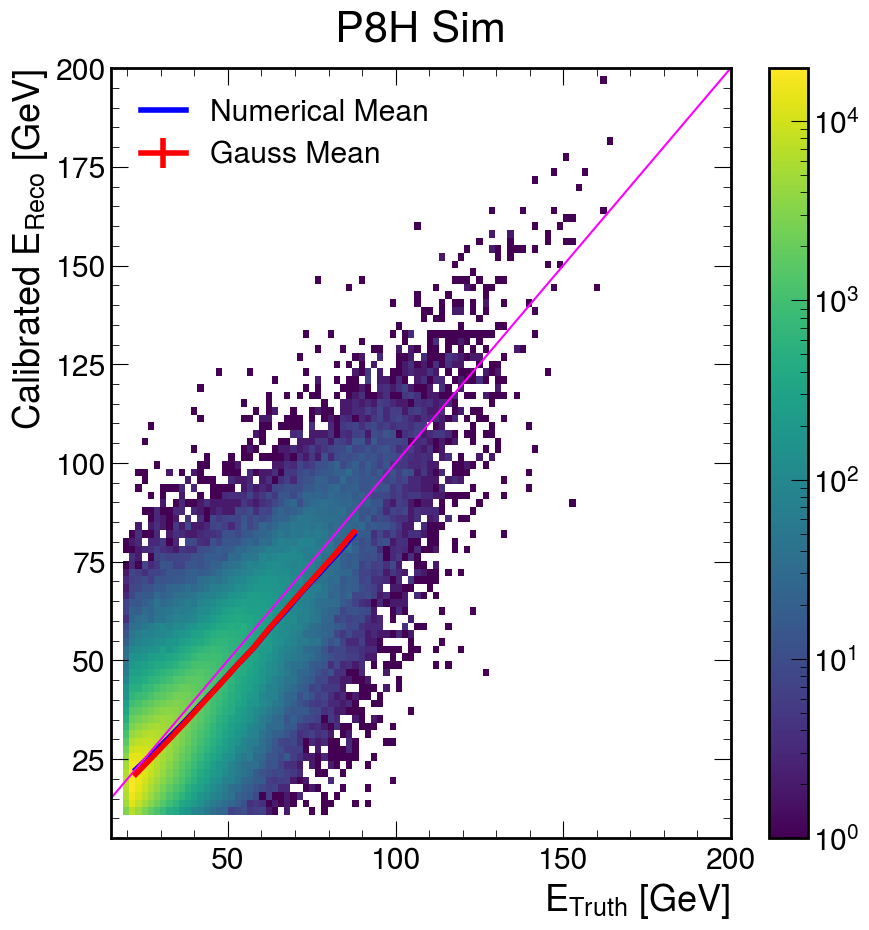

In [44]:
plt.hist2d(np.array(PairedGenEtest),np.array(correctedReco),bins=(100,100),range=([15,200],[5,200]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()
plt.errorbar(np.array(bin_centres)+(width/2), CAvgEReco, yerr=CAvgERecoErr,color='red',label="Gauss Mean",linewidth=4)
plt.plot(np.array(bin_centres)+(width/2), CNumEReco, color='blue',label="Numerical Mean",linewidth=4)
plt.plot(np.linspace(0,200,1000),np.linspace(0,200,1000),color='magenta')
plt.legend(loc="upper left")
#print(CNumEReco) 
plt.xlabel(r'$E_{Truth}$ [GeV]') 
plt.ylabel(r'Calibrated $E_{Reco}$ [GeV]')
plt.title("{} Sim".format(generator),pad = 20.0)
plt.show()

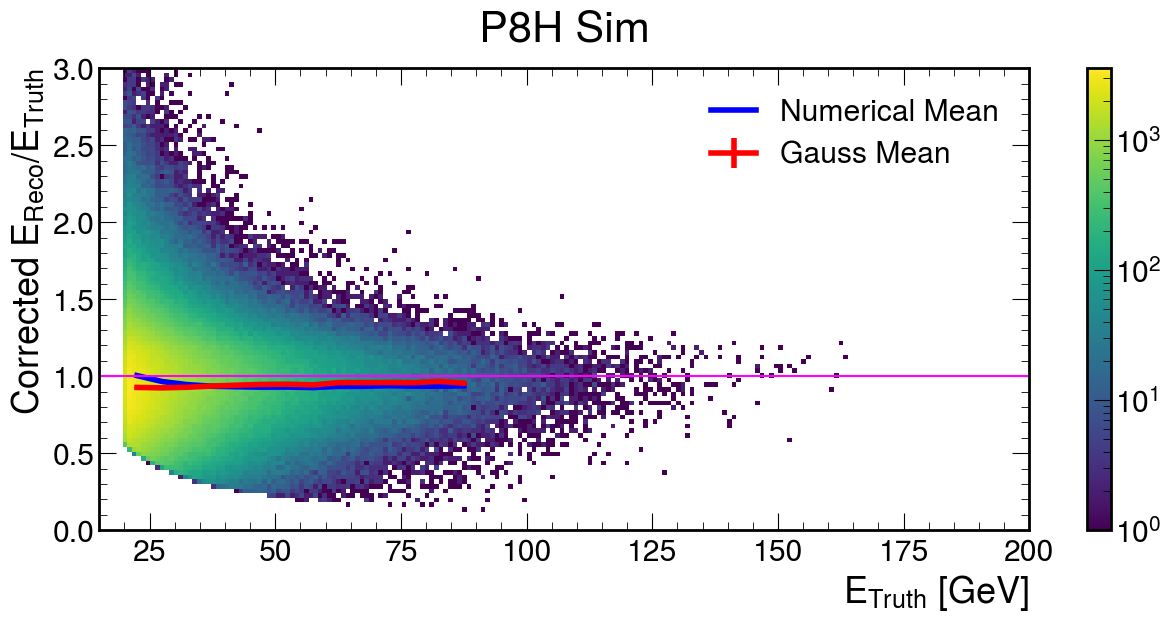

In [45]:
fig = plt.figure(figsize=(15,6))



plt.hist2d(np.array(PairedGenEtest),np.array(JetRC),bins=(200,100),range=([15,200],[0,3]),cmap='viridis',norm=abc.colors.LogNorm())
cbar = plt.colorbar()

plt.errorbar(np.array(bin_centres)+(width/2), CAvgR, yerr=CAvgRErr,color='red',label="Gauss Mean",linewidth=4)
plt.plot(np.array(bin_centres)+(width/2), CNumR, color='blue',label="Numerical Mean",linewidth=4)
plt.plot(np.linspace(0,200,1000),np.ones(1000),color='magenta')
plt.legend(loc="upper right")
plt.xlabel(r'$E_{Truth}$ [GeV]')
plt.ylabel(r'Corrected $E_{Reco}$/$E_{Truth}$')
plt.title("{} Sim".format(generator),pad = 20.0)
plt.show()

In [15]:
with open('Pi0Data_R_0.5_dR_0.25.pickle'.format(generator), 'rb') as handle:
    data_dict = pickle.load(handle)

JetEData = ak.flatten(data_dict["energy"])
JetEtaData = ak.flatten(data_dict["eta"])
JetPhiData = ak.flatten(data_dict["phi"])
correctedData = np.array(JetEData) / correct(JetEData, A, B)

JetEta = ak.flatten(reco_dict_test["eta"])
JetPhi = ak.flatten(reco_dict_test["phi"])
JetE = ak.flatten(reco_dict_test["energy"])
#correctedAllReco

In [16]:
print(len(data_dict["energy"]))

4106803


Text(0, 1, 'Norm. Count')

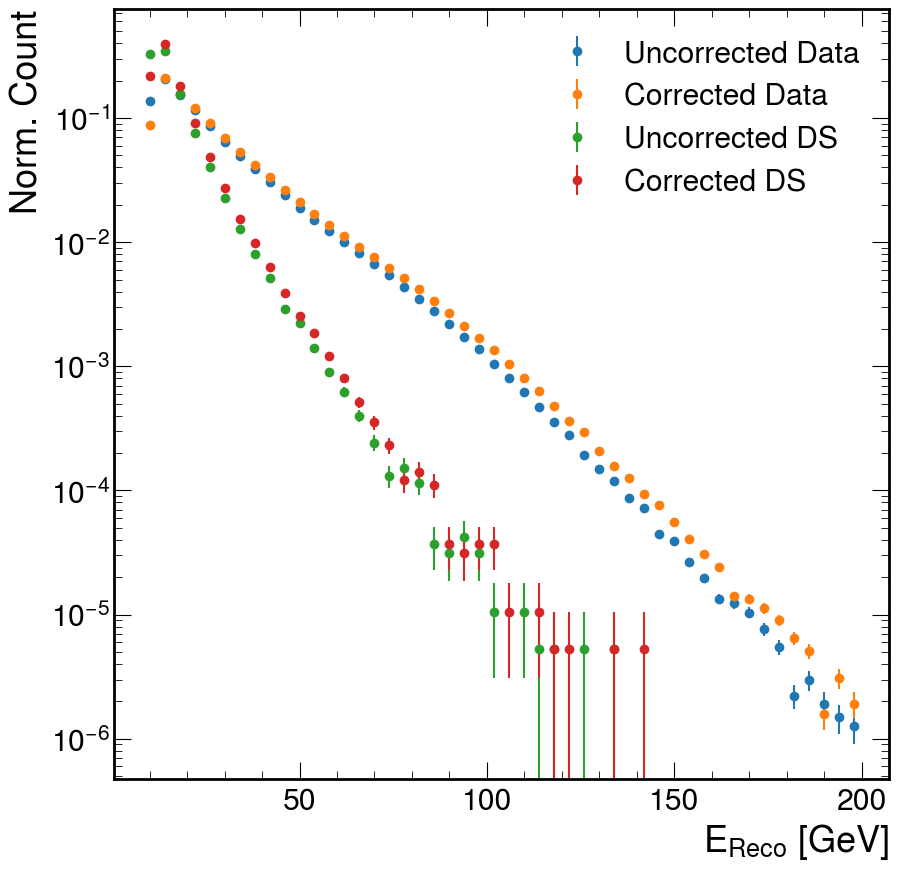

In [17]:
#fig, axs=plt.subplots(2, 1, figsize=(15,6),sharex=True)

#plt.sca(axs[0])

hist, bin_edges = np.histogram(JetEData,bins=50,range=(0,200))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
zerocut = (hist > 0)
errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
hist = hist[zerocut] / np.sum(hist[zerocut])
bins = bin_centres[zerocut]
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o", label = "Uncorrected Data")


hist, bin_edges = np.histogram(correctedData,bins=50,range=(0,200))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
zerocut = (hist > 0)
errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
hist = hist[zerocut] / np.sum(hist[zerocut])
bins = bin_centres[zerocut]
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o", label = "Corrected Data")

hist, bin_edges = np.histogram(allRecoE,bins=50,range=(0,200))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
zerocut = (hist > 0)
errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
hist = hist[zerocut] / np.sum(hist[zerocut])
bins = bin_centres[zerocut]
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o", label = "Uncorrected {}".format(generator))

hist, bin_edges = np.histogram(correctedAllReco,bins=50,range=(0,200))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
    
zerocut = (hist > 0)
errs = np.sqrt(hist[zerocut]) / np.sum(hist[zerocut])
hist = hist[zerocut] / np.sum(hist[zerocut])
bins = bin_centres[zerocut]
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres[zerocut]),np.array(hist),yerr=errs,fmt="o", label = "Corrected {}".format(generator))
plt.yscale("log")
plt.legend()
plt.xlabel("$E_{Reco}$ [GeV]")
plt.ylabel("Norm. Count")

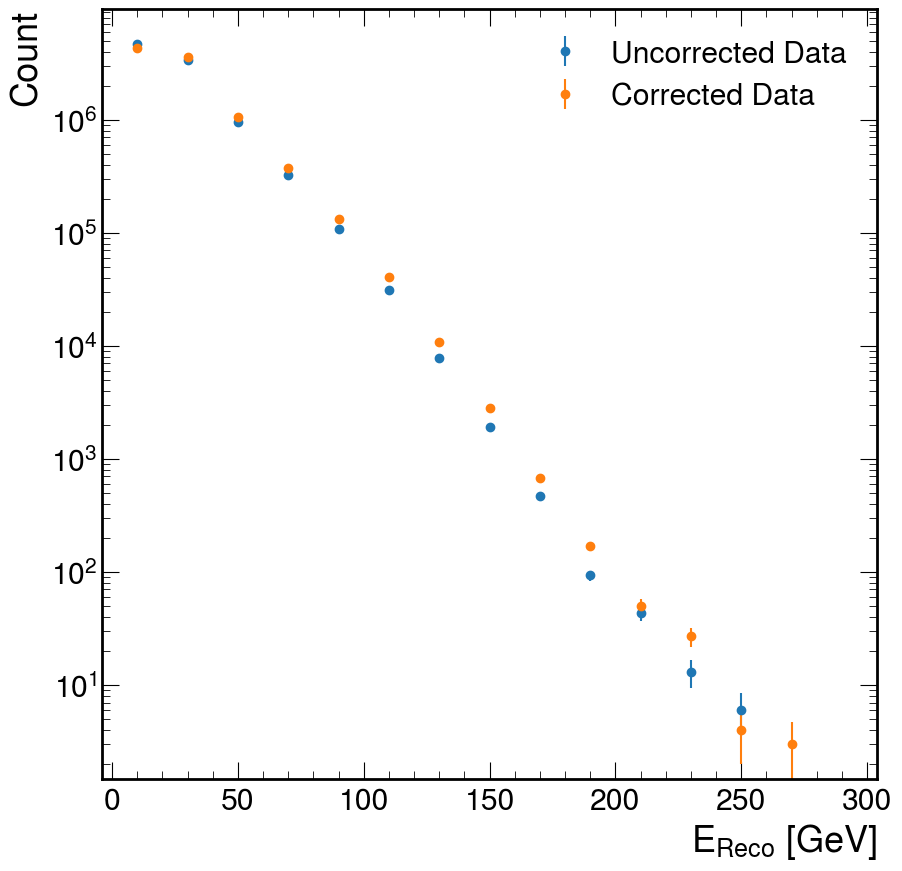

In [18]:
hist, bin_edges = np.histogram(JetEData,bins=15,range=(0,300))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)

bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Uncorrected Data")



hist, bin_edges = np.histogram(correctedData,bins=15,range=(0,300))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist) 
bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Corrected Data")

plt.yscale("log")
plt.legend()
plt.xlabel("$E_{Reco}$ [GeV]")
plt.ylabel("Count")

spectra = ak.zip(
    {
        "Bins": np.array(bin_centres),
        "Count": np.array(hist)
    })


with open('JetDataECorrected.pickle', 'wb') as f:
    pickle.dump((spectra),  f)



In [19]:
DataJetPT = correctedData / np.cosh(JetEtaData)
DataJetPZ = DataJetPT * np.sinh(JetEtaData)


DataJetPTUC = JetEData / np.cosh(JetEtaData)
DataJetPZUC = DataJetPTUC * np.sinh(JetEtaData)


JetPT = correctedAllReco / np.cosh(JetEta)
JetPZ = JetPT * np.sinh(JetEta)

JetPTUC = JetE / np.cosh(JetEta)
JetPZUC = JetPTUC * np.sinh(JetEta)

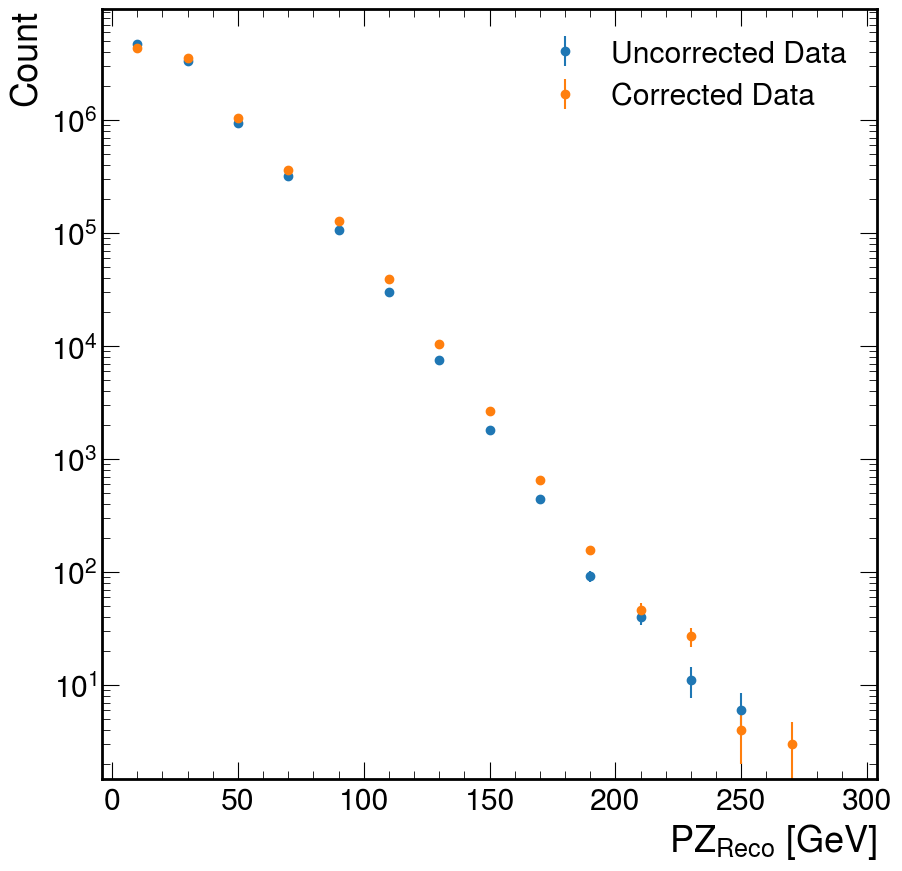

In [20]:
hist, bin_edges = np.histogram(DataJetPZUC,bins=15,range=(0,300))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)

bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Uncorrected Data")


hist, bin_edges = np.histogram(DataJetPZ,bins=15,range=(0,300))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)

bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Corrected Data")



plt.yscale("log")
plt.legend()
plt.xlabel("$PZ_{Reco}$ [GeV]")
plt.ylabel("Count")

spectra = ak.zip(
    {
        "Bins": np.array(bin_centres),
        "Count": np.array(hist)
    })


with open('JetDataPZCorrected.pickle', 'wb') as f:
    pickle.dump((spectra),  f)

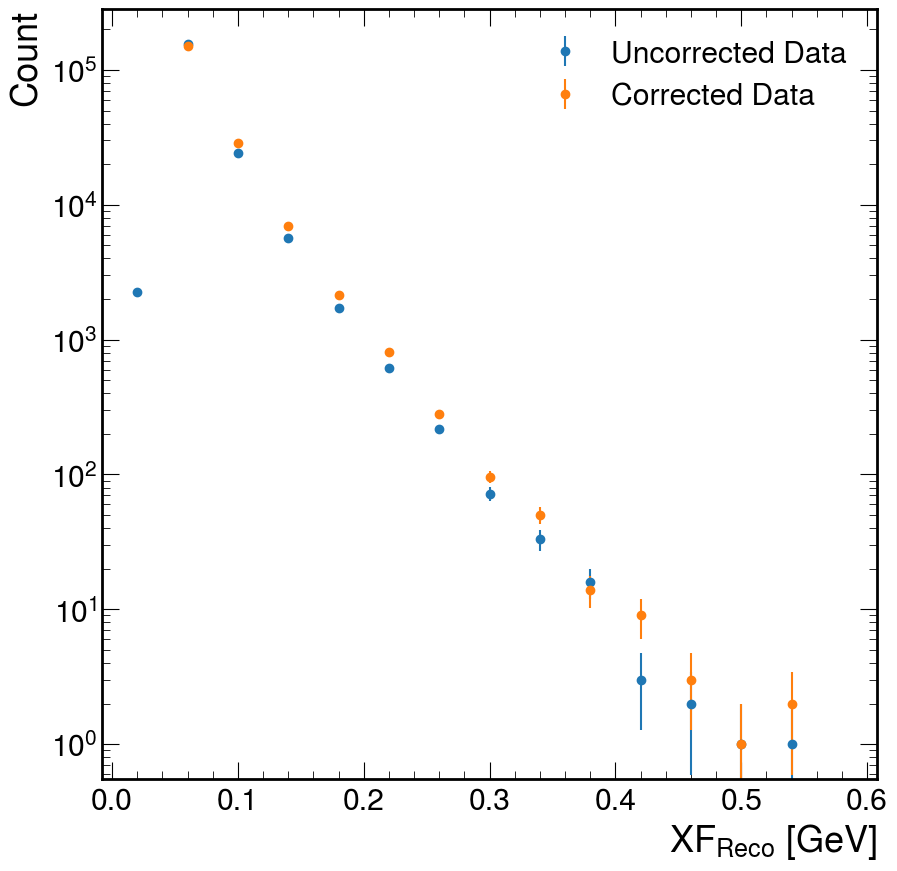

In [21]:
hist, bin_edges = np.histogram(JetPZUC,bins=15,range=(0,150))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_centres = 2 * bin_centres / 500
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Uncorrected Data")


hist, bin_edges = np.histogram(JetPZ,bins=15,range=(0,150))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)


    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
bin_centres = 2 * bin_centres / 500
plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", label = "Corrected Data")



plt.yscale("log")
plt.legend()
plt.xlabel("$XF_{Reco}$ [GeV]")
plt.ylabel("Count")

spectra = ak.zip(
    {
        "Bins": np.array(bin_centres),
        "Count": np.array(hist)
    })


with open('JetDataPZCorrected.pickle', 'wb') as f:
    pickle.dump((spectra),  f)

In [22]:
AXF = [-0.534, -0.434, -0.355, -0.238, -0.151, 0.151, 0.238, 0.355, 0.434, 0.534]
AAN = [ -0.00481, -0.00511, -0.00039, 0.00017, -0.00094, 0.0007, 0.00116, 0.00237, 0.00192, 0.00926]
AD = [0.00381, 0.00139, 0.00053, 0.00023, 0.00016, 0.00016, 0.00022, 0.00052, 0.00135, 0.00370]

/home/sean/miniconda3/envs/test-env/lib/python3.11/site-packages/awkward/_connect/numpy.py:395: RuntimeWarning: divide by zero encountered in divide
  result = impl(*args, **kwargs)


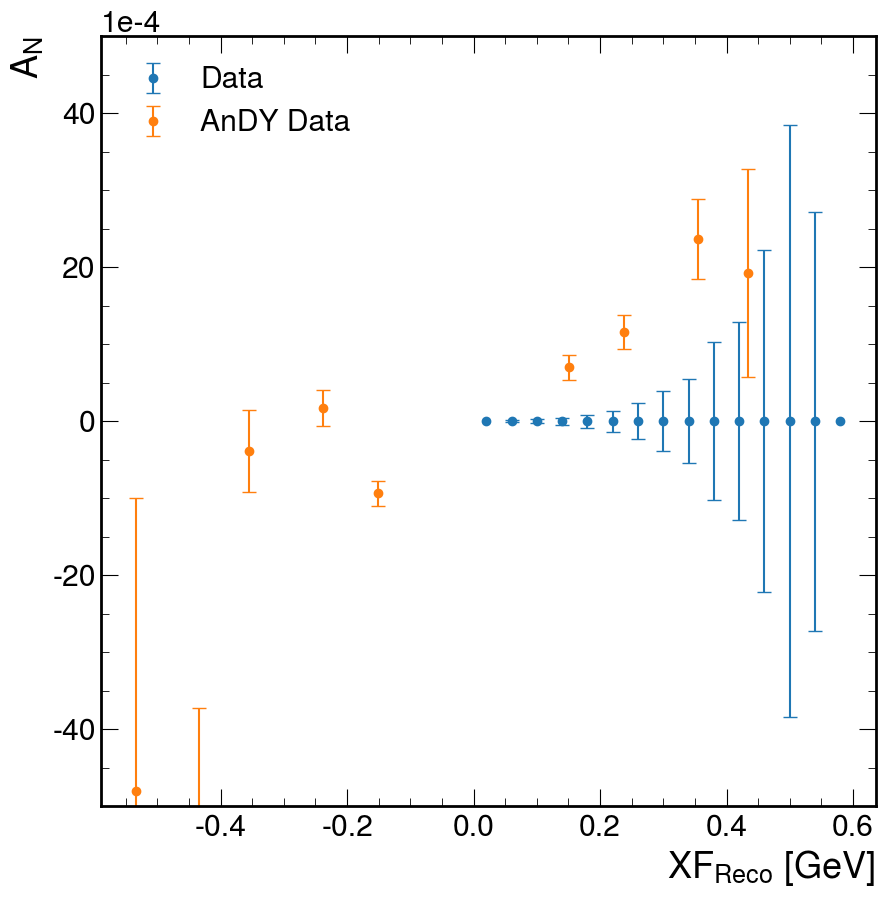

In [23]:
hist, bin_edges = np.histogram(JetPZUC,bins=15,range=(0,150))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)

bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

bin_centres = 2 * bin_centres / 500

errs = 1 / (.5 * np.sqrt(hist*1.35*1000000))
hist = np.zeros(len(hist))

#plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", capsize=5, label = "Uncorrected Data (Projected)")


hist, bin_edges = np.histogram(JetPZ,bins=15,range=(0,150))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
   
errs = np.sqrt(hist)

bins = bin_centres
    
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

bin_centres = 2 * bin_centres / 500

errs = 1 / ( np.sqrt(0.05 * hist*1.35*1000000))
hist = np.zeros(len(hist))

plt.errorbar(np.array(bin_centres),np.array(hist),yerr=errs,fmt="o", capsize=5, label = "Data")

plt.errorbar(AXF, AAN, yerr=AD, fmt="o",capsize=5, label = "AnDY Data")


plt.ylim(-0.005,0.005)

plt.legend()
plt.xlabel("$XF_{Reco}$ [GeV]")
plt.ylabel("$A_{N}$")
plt.ticklabel_format(axis='y', style='sci',scilimits=(-4,-4))

